## Brain Tumor Classification Using Deep Learning Techniques

### Task Evaluation:

This notebook focuses on **Brain Tumor Classification using Deep Learning**. The steps completed include:

1.  **Data Loading and Preparation**:
    *   The dataset was loaded from a zip file and extracted.
    *   Images in the 'yes' and 'no' directories were renamed for consistency.
    *   The initial counts of tumorous and non-tumorous images were checked and visualized.
    *   Data augmentation was performed to increase the number of training samples and address class imbalance.
    *   The augmented data counts were verified and visualized.
    *   A function `crop_brain_tumor` was defined and demonstrated to preprocess images by cropping the brain region.
    *   The cropping function was applied to all images in the augmented dataset.
    *   A `load_data` function was created to load and preprocess the cropped images, resize them, normalize pixel values, and shuffle the dataset.
    *   Sample images from the loaded data were plotted.
    *   Directories for training, testing, and validation datasets were created.
    *   The augmented data was split and copied into the respective train, test, and validation directories.

2.  **Model Development and Training**:
    *   ImageDataGenerators were set up for data augmentation during training and for scaling pixel values in the test and validation sets.
    *   Generators were created to load images in batches from the train, test, and validation directories.
    *   A VGG19 base model was loaded with pre-trained weights from ImageNet, excluding the top classification layer.
    *   A new classification head was added to the VGG19 base model, consisting of Flatten, Dense, and Dropout layers.
    *   The initial VGG19 layers were frozen (not trainable).
    *   The first model (`model_01`) was compiled with the SGD optimizer and categorical cross-entropy loss.
    *   Callbacks for Early Stopping, Model Checkpoint, and ReduceLROnPlateau were defined.
    *   The first model (`model_01`) was trained for 2 epochs with the frozen base model layers.
    *   The training performance (accuracy and loss) of `model_01` was plotted.
    *   The weights of `model_01` were saved.

3.  **Incremental Fine-Tuning**:
    *   A new model (`model_02`) was created, again using VGG19 as the base, and the weights from `model_01` were loaded.
    *   Specific layers in `block5` of the VGG19 base model (`block5_conv4` and `block5_conv3`) were unfrozen to allow for fine-tuning.
    *   `model_02` was compiled with the SGD optimizer.
    *   `model_02` was trained for 2 epochs with the partially unfrozen base model.
    *   The training performance of `model_02` was plotted.
    *   The weights of `model_02` were saved.

4.  **Unfreezing the Entire Network**:
    *   A third model (`model_03`) was created, again using VGG19 as the base, and the weights from `model_02` were loaded.
    *   All layers in the VGG19 base model were unfrozen.
    *   `model_03` was compiled with the SGD optimizer.
    *   `model_03` was trained for 2 epochs with the entire network unfrozen.

5. **Evaluation**:
    * The performance of `model_03` was evaluated on the validation and test sets.
    * The validation and testing loss and accuracy for `model_03` were printed.

This summarizes the key steps taken in the notebook to prepare the data and train and fine-tune a VGG19-based model for brain tumor classification.

In [ ]:
!pip install opencv-python

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
import zipfile
import os

# Specify the ZIP file path
zip_file_path = "archive.zip"

# Check if the file exists
if not os.path.exists(zip_file_path):
    print(f"Error: The file '{zip_file_path}' was not found.")
else:
    # Check if it's a valid zip file
    if zipfile.is_zipfile(zip_file_path):
        # Extract all files
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall("z")  # Extracts to 'z' folder
        print(f"Successfully extracted '{zip_file_path}' to 'z'.")
    else:
        print(f"Error: The file '{zip_file_path}' is not a valid zip file.")

Successfully extracted 'archive.zip' to 'z'.


In [ ]:
folder= 'z/brain_tumor_dataset/yes/'
count=1
for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the yes dir.")

All files are renamed in the yes dir.


In [ ]:
folder = 'z/brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the no dir.")

All files are renamed in the no dir.


In [ ]:
listyes = os.listdir("z/brain_tumor_dataset/yes")
number_files_yes= len(listyes)
print(number_files_yes)

listno= os.listdir("z/brain_tumor_dataset/no")
number_files_no= len(listno)
print(number_files_no)

155
98


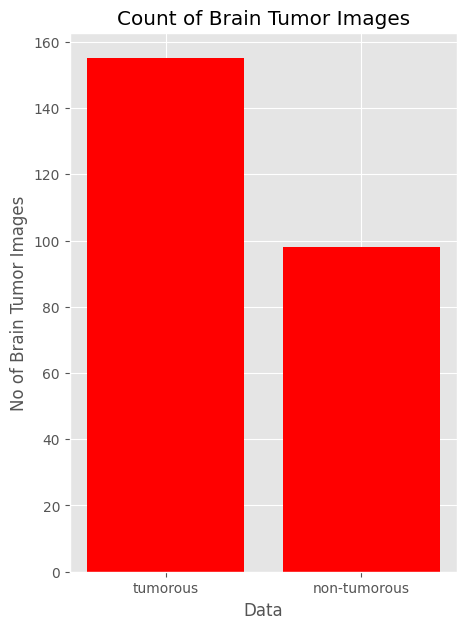

In [ ]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}
typex = data.keys()
values= data.values()

fig= plt.figure(figsize=(5,7))
plt.bar(typex, values, color="red")
plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [ ]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    datagen= ImageDataGenerator(rotation_range=10,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.1,
                                brightness_range=(0.3,1.0),
                                horizontal_flip=True,
                                vertical_flip = True,
                                fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image= cv2.imread(file_dir + '/' +filename)
        image= image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in datagen.flow(x=image, batch_size=1, save_to_dir= save_to_dir, save_prefix=save_prefix, save_format="jpg"):
            i+=1
            if i>n_generated_samples:
                break

In [ ]:
import time
import os
start_time = time.time()
yes_path='z/brain_tumor_dataset/yes/'
no_path= 'z/brain_tumor_dataset/no/'

augmented_data_path = 'augmented_data/'
augmented_data_yes_path = os.path.join(augmented_data_path, 'yes')
augmented_data_no_path = os.path.join(augmented_data_path, 'no')

# Create directories if they don't exist
os.makedirs(augmented_data_yes_path, exist_ok=True)
os.makedirs(augmented_data_no_path, exist_ok=True)


augmented_data(file_dir = yes_path, n_generated_samples=6, save_to_dir=augmented_data_yes_path)
augmented_data(file_dir = no_path, n_generated_samples=9, save_to_dir=augmented_data_no_path)

end_time = time.time()
execution_time = end_time - start_time
print(timing(execution_time))

0:1:32.524527072906494


In [ ]:
def data_summary(main_path):
    yes_path = "augmented_data/yes/"
    no_path = "augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n

    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

In [ ]:
data_summary(augmented_data_path)

Number of sample: 2064
1084 Number of positive sample in percentage: 52.51937984496124%
980 Number of negative sample in percentage: 47.48062015503876%


In [ ]:
listyes = os.listdir("augmented_data/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("augmented_data/no/")
number_files_no = len(listno)
print(number_files_no)

1084
980


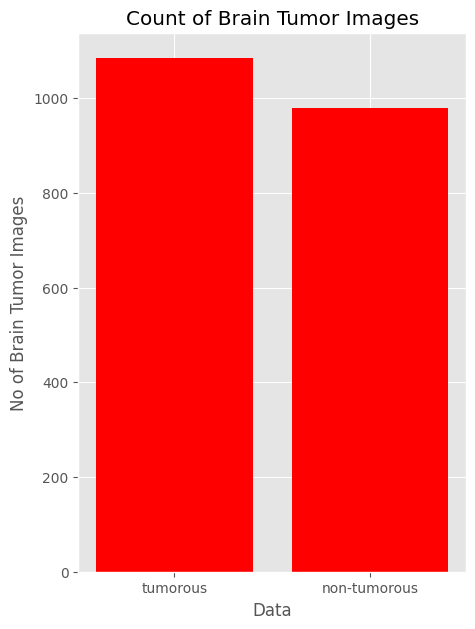

In [ ]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [ ]:
import imutils
def crop_brain_tumor(image, plot=False):
  gray= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray= cv2.GaussianBlur(gray, (5,5), 0)

  THRES= cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  THRES= cv2.erode(THRES, None, iterations=2)
  THRES= cv2.dilate(THRES, None, iterations=2)

  # Find contours in the thresholded image
  cnts = cv2.findContours(THRES.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  # Handle different OpenCV versions
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]

  if not cnts:
      print("No contours found.")
      return None

  c= max(cnts, key=cv2.contourArea)
  extLeft = tuple(c[c[:,:,0].argmin()][0])
  extRight = tuple(c[c[:,:,0].argmax()][0])
  extTop = tuple(c[c[:,:,1].argmin()][0])
  extBot = tuple(c[c[:,:,1].argmax()][0])
  new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

  if plot:
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.tick_params(axis='both', which='both',
                    top=False, bottom= False, left=False, right= False,
                    labelbottom=False, labeltop=False, labelleft=False, labelright=False)

    plt.subplot(1,2,2)
    plt.imshow(new_image)
    plt.title("Cropped Image")
    plt.tick_params(axis='both', which='both',
                    top=False, bottom= False, left=False, right= False,
                    labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.show()

  return new_image

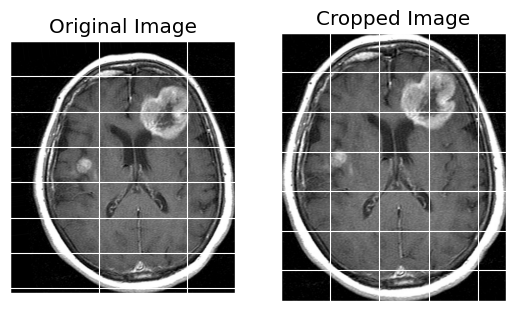

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
import imutils

augmented_yes_dir = 'augmented_data/yes/'

# Get a list of files in the augmented data directory
image_files = os.listdir(augmented_yes_dir)

if not image_files:
    print(f"Error: No image files found in {augmented_yes_dir}")
else:
    # Select the first image file from the list
    image_path = os.path.join(augmented_yes_dir, image_files[0])

    if not os.path.exists(image_path):
        print(f"Error: Image file not found at {image_path}")
    else:
        img = cv2.imread(image_path)

        if img is None:
            print(f"Error: Could not load image from {image_path}. Check file integrity.")
        else:
            crop_brain_tumor(img, True)

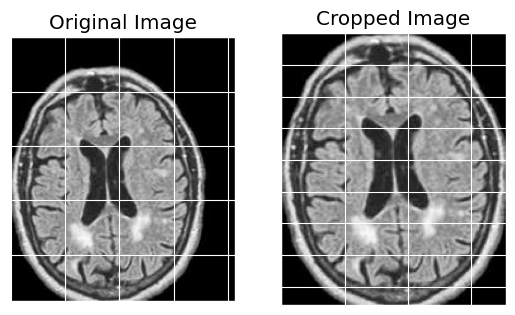

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
import imutils

augmented_no_dir = 'augmented_data/no/'

# Get a list of files in the augmented data directory
image_files = os.listdir(augmented_no_dir)

if not image_files:
    print(f"Error: No image files found in {augmented_no_dir}")
else:
    # Select the first image file from the list
    image_path = os.path.join(augmented_no_dir, image_files[0])

    if not os.path.exists(image_path):
        print(f"Error: Image file not found at {image_path}")
    else:
        img = cv2.imread(image_path)

        if img is None:
            print(f"Error: Could not load image from {image_path}. Check file integrity.")
        else:
            crop_brain_tumor(img, True)

In [ ]:
folder1='augmented_data/no/'
folder2='augmented_data/yes/'

for filename in os.listdir(folder1):
  img=cv2.imread(folder1 + filename)
  img= crop_brain_tumor(img, False)
  cv2.imwrite(folder1+filename, img)
for filename in os.listdir(folder2):
  img=cv2.imread(folder2 + filename)
  img= crop_brain_tumor(img, False)
  cv2.imwrite(folder2+filename, img)

In [ ]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
  X=[]
  Y=[]
  image_width, image_height= image_size

  for directory in dir_list:
    for filename in os.listdir(directory):
      image=cv2.imread(directory + '/'+filename)
      image=crop_brain_tumor(image, plot= False)
      image= cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
      image= image/255.0
      X.append(image)
      if directory[-3:]=="yes":
        Y.append(1)
      else:
        Y.append(0)
  X=np.array(X)
  Y=np.array(Y)

  X,Y =shuffle(X,Y)
  print(f"Number of example is {len(X)}")
  print(f"X shape is: {X.shape}")
  print(f"Y shape is {Y.shape}")
  return X,Y

In [ ]:
augmented_path= 'augmented_data/'
augmented_yes= augmented_path + 'yes'
augmented_no= augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT= (240, 240)

X,Y= load_data([augmented_yes, augmented_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of example is 2064
X shape is: (2064, 240, 240, 3)
Y shape is (2064,)


In [ ]:
def plot_sample_images(X, Y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(Y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

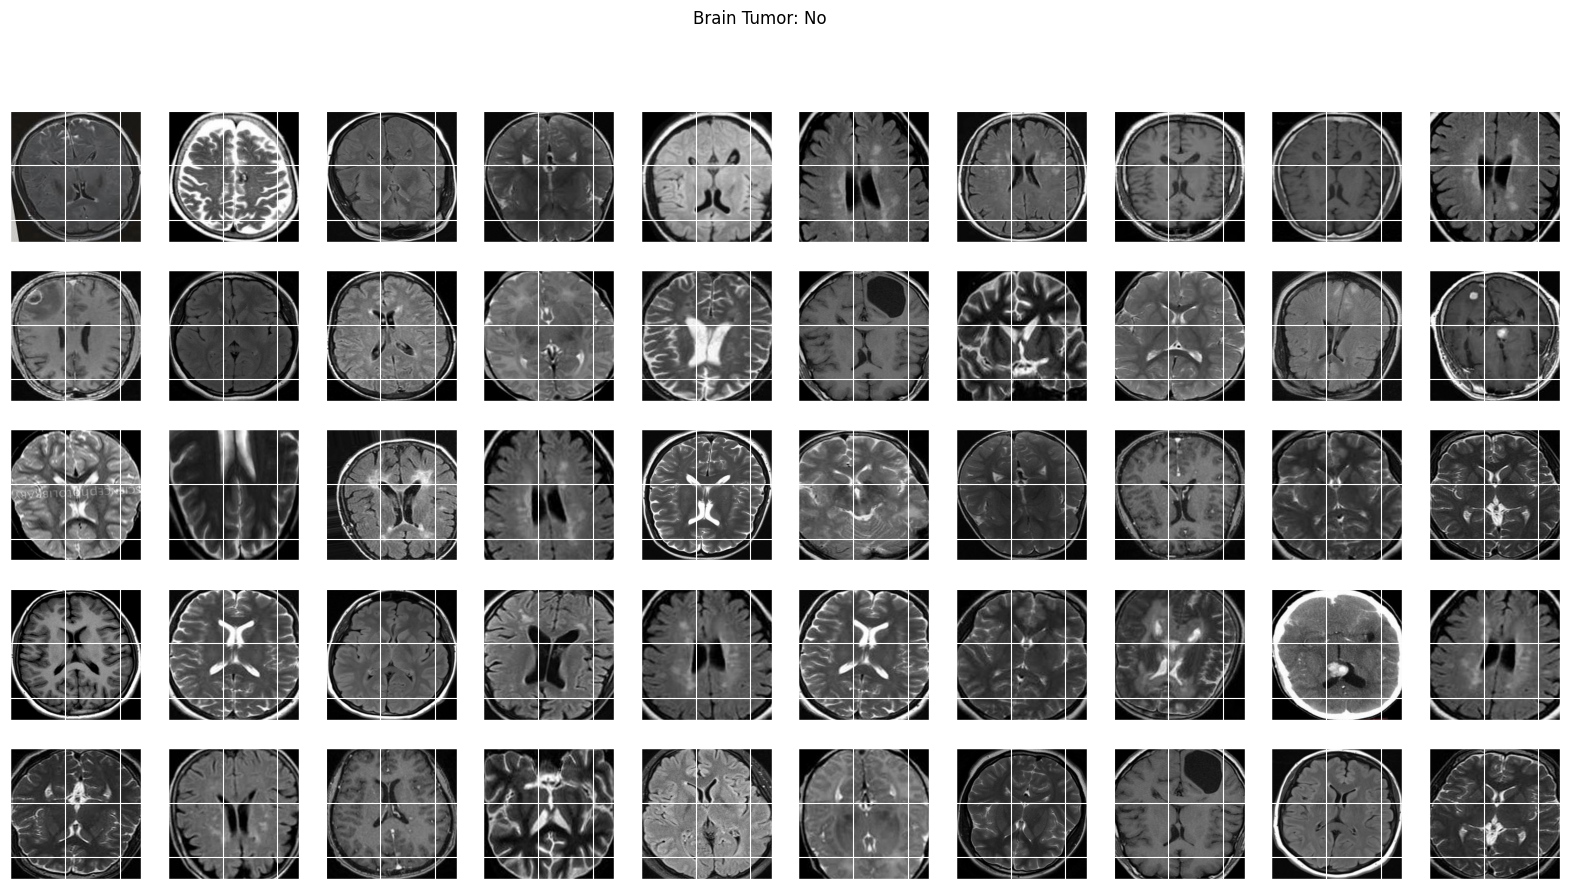

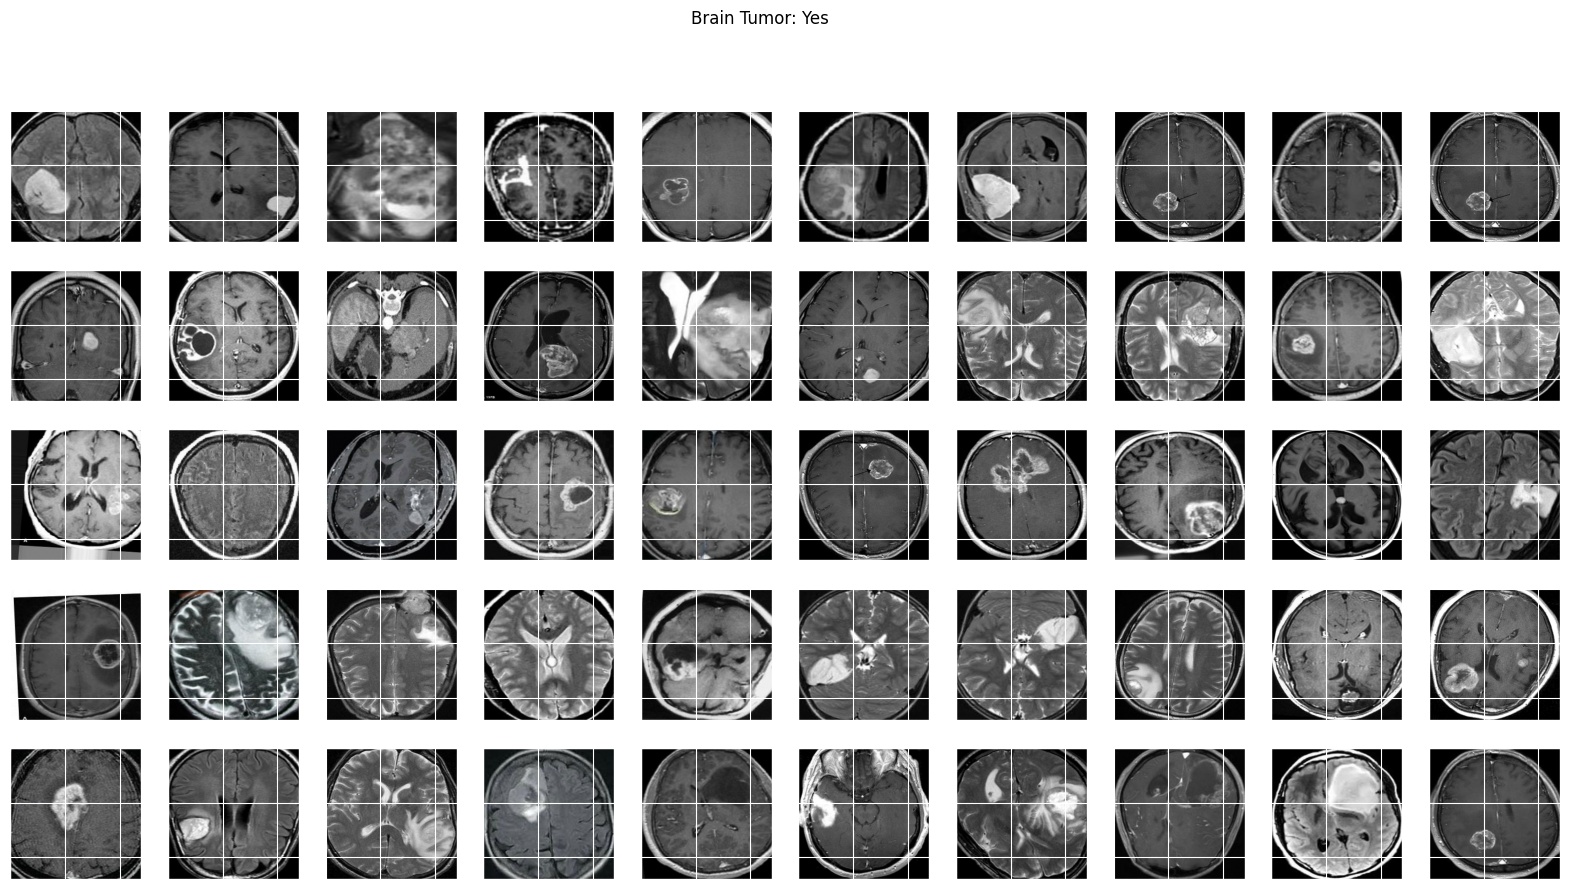

In [ ]:
plot_sample_images(X,Y)

In [ ]:
if not os.path.isdir('tumorous_and_non_tumorous_images'):
    base_dir= 'tumorous_and_non_tumorous_images'
    os.mkdir(base_dir)

In [ ]:
import os

if not os.path.isdir('tumorous_and_non_tumorous_images'):
    base_dir= 'tumorous_and_non_tumorous_images'
    os.mkdir(base_dir)
else:
    base_dir= 'tumorous_and_non_tumorous_images' # Define base_dir even if it exists


train_dir= os.path.join(base_dir, 'train')
test_dir= os.path.join(base_dir, 'test')
validation_dir= os.path.join(base_dir, 'validation')

if not os.path.isdir(train_dir):
  os.mkdir(train_dir)
if not os.path.isdir(test_dir):
  os.mkdir(test_dir)
if not os.path.isdir(validation_dir):
  os.mkdir(validation_dir)

In [ ]:
import os

# Define subdirectories within train, test, and validation
train_tumorous_dir = os.path.join(train_dir, 'tumorous')
train_non_tumorous_dir = os.path.join(train_dir, 'non-tumorous')
test_tumorous_dir = os.path.join(test_dir, 'tumorous')
test_non_tumorous_dir = os.path.join(test_dir, 'non-tumorous')
validation_tumorous_dir = os.path.join(validation_dir, 'tumorous')
validation_non_tumorous_dir = os.path.join(validation_dir, 'non-tumorous')


if not os.path.isdir(train_tumorous_dir):
  os.mkdir(train_tumorous_dir)
if not os.path.isdir(train_non_tumorous_dir):
  os.mkdir(train_non_tumorous_dir)

if not os.path.isdir(test_tumorous_dir):
  os.mkdir(test_tumorous_dir)
if not os.path.isdir(test_non_tumorous_dir):
  os.mkdir(test_non_tumorous_dir)

if not os.path.isdir(validation_tumorous_dir):
    os.mkdir(validation_tumorous_dir)
if not os.path.isdir(validation_non_tumorous_dir):
    os.mkdir(validation_non_tumorous_dir)

In [ ]:
original_dataset_tumorours = os.path.join('augmented_data','yes/')
original_dataset_nontumorours = os.path.join('augmented_data','no/')

In [ ]:
import shutil
import os

files= os.listdir('augmented_data/yes/')
fnames=[]
for i in range (0,759):
  fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(train_tumorous_dir, fname) # Corrected variable name
    shutil.copyfile(src, dst)

In [ ]:
import shutil
import os

files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(759,922):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(test_tumorous_dir, fname) # Corrected variable name
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(759,922):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(validation_tumorous_dir, fname) # Corrected variable name
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(0,686):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(train_non_tumorous_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(686,833):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(test_non_tumorous_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(833,979):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(validation_non_tumorous_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen= ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=0.4,
                                  vertical_flip=0.4,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  rotation_range=40,
                                  width_shift_range=0.4,
                                  height_shift_range=0.4,
                                  fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1.0/255) # Corrected: Assign to a variable
validation_datagen = ImageDataGenerator(rescale=1.0/255) # Corrected: Assign to a variable

In [ ]:
train_generator= train_datagen.flow_from_directory(train_dir, batch_size=32, class_mode='categorical', shuffle= True, seed=42, color_mode='rgb', target_size=(240,240))

Found 1445 images belonging to 2 classes.


In [ ]:
test_generator= test_datagen.flow_from_directory(test_dir, batch_size=32, class_mode='categorical', shuffle= True, seed=42, color_mode='rgb', target_size=(240,240))

Found 310 images belonging to 2 classes.


In [ ]:
validation_generator= train_datagen.flow_from_directory(validation_dir, batch_size=32, class_mode='categorical', shuffle= True, seed=42, color_mode='rgb', target_size=(240,240))

Found 309 images belonging to 2 classes.


In [ ]:
class_labels= train_generator.class_indices
print(class_labels)
class_name = {value: key for (key,value) in class_labels.items()}

{'non-tumorous': 0, 'tumorous': 1}


In [ ]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
filepath = 'model.h5'
es = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuarcy', patience=3, verbose = 1, factor = 0.5, min_lr = 0.0001)

In [ ]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_01.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
history_01= model_01.fit(train_generator, steps_per_epoch=10,epochs=2, callbacks=[es,cp,lrr], validation_data= validation_generator)

Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.5084 - loss: 0.7633
Epoch 1: val_loss improved from inf to 0.71506, saving model to model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 5s/step - accuracy: 0.5099 - loss: 0.7616 - val_accuracy: 0.5178 - val_loss: 0.7151 - learning_rate: 1.0000e-04
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.4645 - loss: 0.7923
Epoch 2: val_loss improved from 0.71506 to 0.67383, saving model to model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.4686 - loss: 0.7884 - val_accuracy: 0.5987 - val_loss: 0.6738 - learning_rate: 1.0000e-04


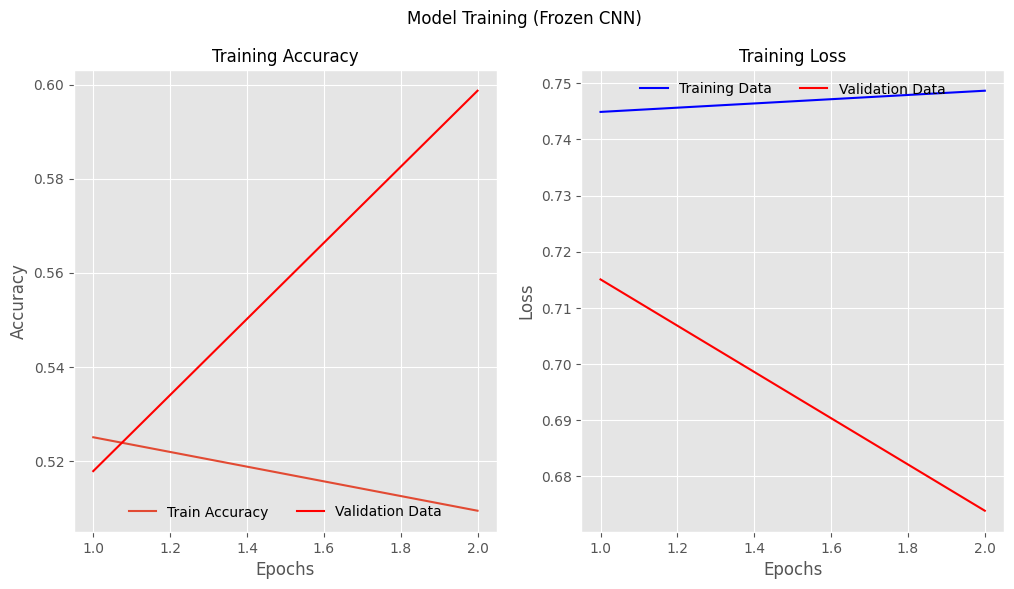

In [ ]:
#Plot performance of model

fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch= len(history_01.history['accuracy'])+1
list_epoch= list(range(1,max_epoch))

ax1.plot(list_epoch, history_01.history['accuracy'], label='Train Accuracy')
ax1.plot(list_epoch, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(list_epoch, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(list_epoch, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [ ]:
if not os.path.isdir('model_weights/'):
  os.mkdir('model_weights/')
model_01.save_weights(filepath="model_weights/model_01.weights.h5", overwrite=True)

In [ ]:
model_01.load_weights("model_weights/model_01.weights.h5")
vgg_val_eval_01 = model_01.evaluate(validation_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 939ms/step - accuracy: 0.5329 - loss: 0.6812
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5524 - loss: 0.6833


In [ ]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation Acc: {vgg_val_eval_01[1]}')
print(f'Testing Loss: {vgg_test_eval_01[0]}')
print(f'Testing Acc: {vgg_test_eval_01[1]}')

Validation Loss: 0.6819760203361511
Validation Acc: 0.5242718458175659
Testing Loss: 0.6696603298187256
Testing Acc: 0.5709677338600159


In [ ]:
filenames= test_generator.filenames
nb_samples= len(test_generator)

vgg_prediction_01= model_01.predict(test_generator, steps=nb_samples, verbose=1)
y_pred= np.argmax(vgg_prediction_01, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 318ms/step


In [ ]:
#Increamental Freezing and Fine-Tuning of Model

base_model= VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names= [layer.name for layer in base_model.layers]
print(base_model_layer_names)

['input_layer_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']


In [ ]:
x= base_model.output
flat= Flatten()(x)

class_1= Dense(4608, activation='relu')(flat)
drop_out= Dropout(0.2)(class_1)
class_2= Dense(1152, activation='relu')(drop_out)
output= Dense(2, activation= 'softmax')(class_2)

model_02= Model(base_model.inputs, output)
model_02.load_weights("model_weights/model_01.weights.h5")

set_trainable= False
for layer in base_model.layers:
  if layer.name in ['block5_conv4', 'block5_conv3']:
    set_trainable= True
  if set_trainable:
    layer.trainable= True
  else:
    layer.trainable= False

print(model_02.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 125,641,602 (479.28 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

None


In [ ]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_02.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [ ]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs = 2, callbacks=[es,cp,lrr], validation_data=validation_generator)

Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.5746 - loss: 0.6997
Epoch 1: val_loss improved from 0.67383 to 0.66826, saving model to model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.5741 - loss: 0.6988 - val_accuracy: 0.5793 - val_loss: 0.6683 - learning_rate: 1.0000e-04
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.5439 - loss: 0.7229
Epoch 2: val_loss improved from 0.66826 to 0.65674, saving model to model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5422 - loss: 0.7232 - val_accuracy: 0.5987 - val_loss: 0.6567 - learning_rate: 1.0000e-04


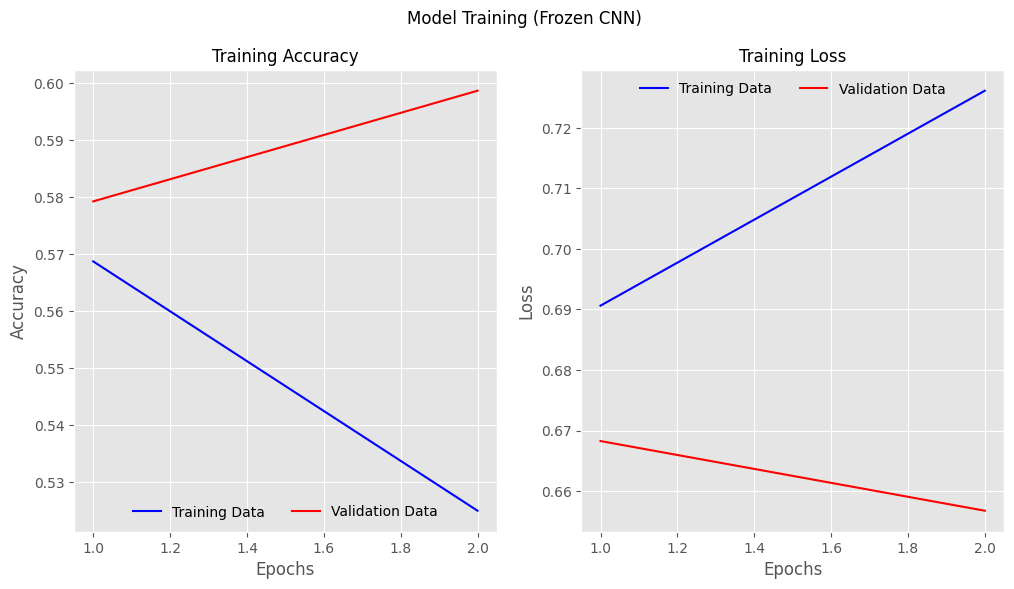

In [ ]:
#Plot Performance

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_02.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_02.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_02.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_02.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [ ]:
if not os.path.isdir('model_weights/'):
  os.mkdir('model_weights/')
model_02.save_weights(filepath="model_weights/model_02.weights.h5", overwrite=True)

In [ ]:
#Unfreezing The Enitre Network

base_model= VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names= [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat= Flatten()(x)

class_1= Dense(4608, activation='relu')(flat)
drop_out= Dropout(0.2)(class_1)
class_2= Dense(1152, activation='relu')(drop_out)
output= Dense(2, activation= 'softmax')(class_2)

model_03= Model(base_model.inputs, output)
model_03.load_weights("model_weights/model_02.weights.h5")

sgd= SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model_03.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
model_03.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 140,946,370 (537.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_03 = model_03.fit(train_generator, steps_per_epoch=10, epochs = 2, callbacks=[es,cp,lrr], validation_data=validation_generator)

Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.5540 - loss: 0.6863
Epoch 1: val_loss did not improve from 0.65674
10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5551 - loss: 0.6864 - val_accuracy: 0.6214 - val_loss: 0.6581 - learning_rate: 1.0000e-04
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6353 - loss: 0.6569   
Epoch 2: val_loss did not improve from 0.65674
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.6334 - loss: 0.6568 - val_accuracy: 0.5728 - val_loss: 0.6678 - learning_rate: 1.0000e-04


In [ ]:
model_03.load_weights("model_weights/model_02.weights.h5")
vgg_val_eval_03 = model_03.evaluate(validation_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 492ms/step - accuracy: 0.5932 - loss: 0.6509
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - accuracy: 0.6314 - loss: 0.6391


In [ ]:
print(f'Validation Loss for model_03: {vgg_val_eval_03[0]}')
print(f'Validation Accuracy for model_03: {vgg_val_eval_03[1]}')
print(f'Testing Loss for model_03: {vgg_test_eval_03[0]}')
print(f'Testing Accuracy for model_03: {vgg_test_eval_03[1]}')

Validation Loss for model_03: 0.6534038186073303
Validation Accuracy for model_03: 0.6116504669189453
Testing Loss for model_03: 0.6441572904586792
Testing Accuracy for model_03: 0.6193548440933228
